In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from qiskit import QuantumCircuit
from functools import reduce
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA

In [2]:
###Import historical price data
stock_df=pd.read_csv("Historical_Stock_Data.csv")
num_assets=7
stock_df.head()

,Date,AAPL,MSFT,GOOGL,AMZN,DIS,TSLA,CCL
0,2019-04-11 00:00:00-04:00,48.339525,114.741103,60.445000,92.434998,115.930751,17.886667,50.173726
1,2019-04-12 00:00:00-04:00,47.942395,114.836294,60.780998,92.419998,125.955161,18.014668,50.700253
2,2019-04-15 00:00:00-04:00,47.793197,115.121869,61.204498,92.099998,129.047173,17.908667,51.111908
3,2019-04-16 00:00:00-04:00,48.004977,115.788186,61.500000,92.567497,129.736466,17.716667,51.600147
4,2019-04-17 00:00:00-04:00,48.024231,115.407417,61.849998,93.649498,127.826127,18.316668,52.768091


In [3]:
###Compute Returns Timeseries
return_df = (stock_df[[t for t in stock_df.columns if t!="Date"]]-stock_df[[t for t in stock_df.columns if t!="Date"]].shift())/stock_df[[t for t in stock_df.columns if t!="Date"]].shift()
return_df = return_df.loc[1:]
return_df.head()

,AAPL,MSFT,GOOGL,AMZN,DIS,TSLA,CCL
1,-0.008215,0.000830,0.005559,-0.000162,0.086469,0.007156,0.010494
2,-0.003112,0.002487,0.006968,-0.003462,0.024549,-0.005884,0.008119
3,0.004431,0.005788,0.004828,0.005076,0.005341,-0.010721,0.009552
4,0.000401,-0.003288,0.005691,0.011689,-0.014725,0.033866,0.022635
5,0.017941,0.007836,0.006467,-0.002242,0.015099,-0.012812,-0.008527


In [4]:
###Pandas -> Numpy
return_array  = np.array(return_df)

In [5]:
###Set up problem 
mu = np.mean(return_array,axis=0)
sigma= np.array(return_df.cov())
B = 4
c = 0.1
sigma_mu=sigma- np.diag(mu)
A=sigma_mu+np.diag([-2*B*c for i in range(num_assets)])+c*np.ones((num_assets,num_assets))

In [6]:
"Function to compute expectation"
def cost(x):
    return x.dot(A).dot(x)
from qiskit.quantum_info import SparsePauliOp

"Indexed pauli ops (reverse qiskit order)"
def indexedZ(i):
    return SparsePauliOp((num_assets-i-1)*'I' + 'Z' + 'I'*(i))

def indexedY(i):
    return SparsePauliOp((num_assets-i-1)*'I' + 'Y' + 'I'*(i))

def indexedX(i):
    return SparsePauliOp((num_assets-i-1)*'I' + 'X' + 'I'*(i))


"Encoded hamiltonian"
H = 0 * SparsePauliOp('I' * num_assets)
for i in range(num_assets):
    for j in range(num_assets):
        H+=1/4 * A[i][j]* SparsePauliOp('I' * num_assets)-1/2 *  A[i][j]* indexedZ(i)+1/4 * A[i][j] * indexedZ(i) @ indexedZ(j)
H=H.simplify()

"Constrcut Default Mixer"
H_mix = reduce(lambda a,b: a+b, [indexedX(i) for i in range(num_assets)])
default_mixer = QuantumCircuit(num_assets)
default_mixer.append( PauliEvolutionGate(H_mix, Parameter('t')), range(num_assets))

"Normal QAOA ansatz with a initial quantum circuit"
from qiskit.circuit import ParameterVector
def QAOA_Ansatz(cost,mixer,p=1,initial=None):
    qc=QuantumCircuit(num_assets)
    if(initial is None):
        qc.h(range(num_assets))
    else:
        qc = initial.copy()
    Gamma = ParameterVector('γ',p)
    Beta = ParameterVector('β',p)
    for i in range(p):
        if(cost is not None):
            qc.append(PauliEvolutionGate(cost,Gamma[i]),range(num_assets))
        qc.append(mixer.assign_parameters([Beta[i]]),range(num_assets))
    return qc


In [7]:
import cvxpy as cp
from scipy.linalg import sqrtm
"Solve GW-Cut"
def GWcut(reps=1):
    min = None
    min_x = None

    X=cp.Variable((num_assets,num_assets),PSD=True)
    constraints = [X >> 0]
    constraints += [
        X[i,i] == 1 for i in range(num_assets)
    ]
    objective = cp.trace(-A @ X)
    prob = cp.Problem(cp.Maximize(objective),constraints)
    prob.solve()
    x=sqrtm(X.value)
    
    for i in range(reps):

        u = np.random.random(num_assets)
        z=np.array(np.sign(x.real @ u)/2+1/2,dtype=int)
        l=cost(z)
        if(i==0):
            min = l
            min_x = z
        else:
            if(l<min):
                min = l
                min_x = z
    return (min,min_x)
initial = (GWcut(100)[1])

In [8]:
epsilon=0.25
"Warmstart QAOA"
def WarmStartQAOA(initial,cost,p=1,modified=True):
    
    theta = [2*np.arcsin(np.sqrt(1-epsilon)),2*np.arcsin(np.sqrt(epsilon))]

    init_qc= QuantumCircuit(num_assets)
    mixer=QuantumCircuit(num_assets)

    t = Parameter('t')
    for i,v in enumerate(initial):
        init_qc.ry(theta[v],i)
        if(modified):
            mixer.ry(theta[v],i)
            mixer.rz(-2*t,i)
            mixer.ry(-theta[v],i)
        else:
            mixer.ry(-theta[v],i)
            mixer.rz(-2*t,i)
            mixer.ry(theta[v],i)
    return QAOA_Ansatz(cost=cost,mixer=mixer,p=p,initial=init_qc)

In [9]:
opt = COBYLA(maxiter = 10**2) ###Change if needed
def single_circuit_optimization(ansatz):
    history = {"cost": [], "params": []}
    def compute_expectation(x):
        psi = Statevector(ansatz.assign_parameters(x))
        l = psi.expectation_value(H).real
        history["cost"].append(l)
        history["params"].append(x)
        return l
    res = opt.minimize(fun= compute_expectation, x0 = np.random.random(ansatz.num_parameters))
    return res.fun,res.x,history

def circuit_optimization(ansatz,reps=10):
    print("------------Beginning Optimization------------")
    history_list = []
    param_list = []
    cost_list = []
    for i in range(reps):
        cost,params,history = single_circuit_optimization(ansatz)
        history_list.append(history)
        param_list.append(params)
        cost_list.append(cost)
        print(f"Iteration {i} complete")
    return np.array(cost_list),np.array(param_list),history_list

In [10]:
plist = np.array(range(1,5))
ws_costs=[]
ws_param_history = []
for p in plist:
    wsqaoa_ansatz = WarmStartQAOA(initial,H,p=p,modified=False)
    costs,params,history_list=circuit_optimization(wsqaoa_ansatz)
    ws_costs.append(costs)
    ws_param_history.append(params)

mod_ws_costs=[]
mod_ws_param_history = []
for p in plist:
    mod_wsqaoa_ansatz = WarmStartQAOA(initial,H,p=p,modified=True)
    costs,params,history_list=circuit_optimization(mod_wsqaoa_ansatz)
    mod_ws_costs.append(costs)
    mod_ws_param_history.append(params)

q_costs=[]
param_history = []
for p in plist:
    qaoa_ansatz = QAOA_Ansatz(H,default_mixer,p=p)
    costs,params,history_list=circuit_optimization(qaoa_ansatz)
    q_costs.append(costs)
    param_history.append(params)

------------Beginning Optimization------------
Iteration 0 complete
Iteration 1 complete
Iteration 2 complete
Iteration 3 complete
Iteration 4 complete
Iteration 5 complete
Iteration 6 complete
Iteration 7 complete
Iteration 8 complete
Iteration 9 complete
------------Beginning Optimization------------
Iteration 0 complete
Iteration 1 complete
Iteration 2 complete
Iteration 3 complete
Iteration 4 complete
Iteration 5 complete
Iteration 6 complete
Iteration 7 complete
Iteration 8 complete
Iteration 9 complete
------------Beginning Optimization------------
Iteration 0 complete
Iteration 1 complete
Iteration 2 complete
Iteration 3 complete
Iteration 4 complete
Iteration 5 complete
Iteration 6 complete
Iteration 7 complete
Iteration 8 complete
Iteration 9 complete
------------Beginning Optimization------------
Iteration 0 complete
Iteration 1 complete
Iteration 2 complete
Iteration 3 complete
Iteration 4 complete
Iteration 5 complete
Iteration 6 complete
Iteration 7 complete
Iteration 8 co

In [12]:
"Brute Force Solver (Try all Possibilities)"
min_cost = cost(np.zeros(num_assets))
min_x = [cost(np.zeros(num_assets))]
for i in range(2**num_assets):
    x = np.array([x for x in '0'*(num_assets-len(bin(i)[2:]))+bin(i)[2:]],dtype=int)
    if(cost(x) < min_cost):
        min_cost = cost(x)
        min_x  = [x]
    elif(cost(x) == min_cost):
        min_x.append(x)        

In [13]:
print(f"Optimal Solution(s): {min_x}")
print(f"Optimal Cost: {min_cost}")
print(f"GW Cost: {cost(initial)}")

Optimal Solution(s): [array([1, 1, 1, 0, 1, 0, 0])]
Optimal Cost: -1.5994066606373283
GW Cost: -1.5987305456506042


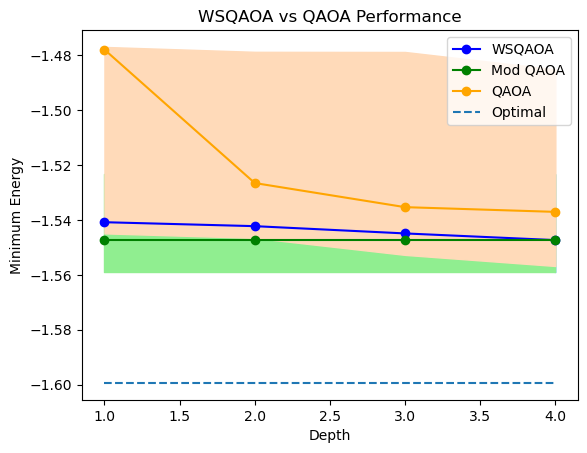

In [21]:
plt.plot(plist,np.median(ws_costs,axis=1),'-o',color='blue',label='WSQAOA')
plt.fill_between(plist,np.min(ws_costs,axis=1),np.max(ws_costs,axis=1),color='skyblue')

plt.plot(plist,np.median(mod_ws_costs,axis=1),'-o',color='green',label='Mod QAOA')
plt.fill_between(plist,np.min(mod_ws_costs,axis=1),np.max(mod_ws_costs,axis=1),color='lightgreen')

plt.plot(plist,np.median(q_costs,axis=1),'-o',color='orange',label='QAOA')
plt.fill_between(plist,np.min(q_costs,axis=1),np.max(q_costs,axis=1),color='peachpuff')

plt.plot(plist,[min_cost for p in plist],'--',label='Optimal')

plt.xlabel('Depth')
plt.ylabel('Minimum Energy')
plt.title('WSQAOA vs QAOA Performance')
plt.legend()

In [14]:
"Find optimal state"
optimal_state = np.zeros(2**num_assets)
optimal_state[sum([2**(i)*v for i,v in enumerate(min_x[0])])] = 1
optimal_state=Statevector(optimal_state)

In [15]:
ws_probs=[]
for i,p in enumerate(plist):
    wsqaoa_ansatz = WarmStartQAOA(initial,H,p=p,modified=False)
    overlaps = []
    for params in ws_param_history[i]:
        circuit_state = Statevector(wsqaoa_ansatz.assign_parameters(params))
        overlaps.append(abs(circuit_state.inner(optimal_state))**2)
    ws_probs.append(overlaps)

mod_ws_probs=[]
for i,p in enumerate(plist):
    mod_wsqaoa_ansatz = WarmStartQAOA(initial,H,p=p,modified=True)
    overlaps = []
    for params in mod_ws_param_history[i]:
        circuit_state = Statevector(mod_wsqaoa_ansatz.assign_parameters(params))
        overlaps.append(abs(circuit_state.inner(optimal_state))**2)
    mod_ws_probs.append(overlaps)

probs=[]
for i,p in enumerate(plist):
    qaoa_ansatz = QAOA_Ansatz(H,default_mixer,p=p)
    overlaps = []
    for params in param_history[i]:
        circuit_state = Statevector(qaoa_ansatz.assign_parameters(params))
        overlaps.append(abs(circuit_state.inner(optimal_state))**2)
    probs.append(overlaps)

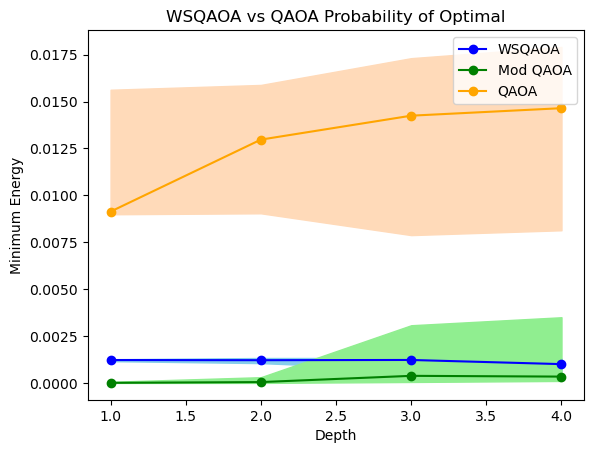

In [16]:
plt.plot(plist,np.median(ws_probs,axis=1),'-o',color='blue',label='WSQAOA')
plt.fill_between(plist,np.min(ws_probs,axis=1),np.max(ws_probs,axis=1),color='skyblue')

plt.plot(plist,np.median(mod_ws_probs,axis=1),'-o',color='green',label='Mod QAOA')
plt.fill_between(plist,np.min(mod_ws_probs,axis=1),np.max(mod_ws_probs,axis=1),color='lightgreen')

plt.plot(plist,np.median(probs,axis=1),'-o',color='orange',label='QAOA')
plt.fill_between(plist,np.min(probs,axis=1),np.max(probs,axis=1),color='peachpuff')
plt.xlabel('Depth')
plt.ylabel('Minimum Energy')
plt.title('WSQAOA vs QAOA Probability of Optimal')
plt.legend()